In [1]:
import numpy as np
import os
import ephem as ep
import statistics as stat
import healpy as hp
from pygdsm import GlobalSkyModel2016
from pygdsm import GlobalSkyModel
import scipy as sci
#import read_vna_csv as cs
from matplotlib import pyplot as plt
import PrizmCalibration as cl
import prizmatoid as pzt
try:
    reload(pzt)
    reload(cl)
except:
    from importlib import reload
    reload(pzt)
    reload(cl)
    

# LOADING ARRAYS


In [2]:
with open('100MHz_EW_antenna_average.npy', 'rb') as f:
    alldataavg = np.load(f)
with open('100MHz_EW_GSM_average.npy', 'rb') as g:
    allgsmavg = np.load(g)
krat = allgsmavg/alldataavg

In [15]:
flow = 60
fhigh = 120

# SVD on K (ratio) 

In [4]:
bone = np.ones((krat.shape[0],krat.shape[1]))
n = krat.shape[0]
r = np.linalg.matrix_rank(krat)
U, σ, VH = np.linalg.svd(krat, full_matrices=True)
V = VH.T

sigma_inv = np.vstack([np.diag(1/σ), np.zeros((n-r,r))])
sigma = np.vstack([np.diag(σ), np.zeros((n-r,r))])
V1=V[:,0:r] 
Sr=sigma_inv[0:r,0:r]
U1=U[:,0:r]

xk = V1 @ Sr @ U1.T @ bone

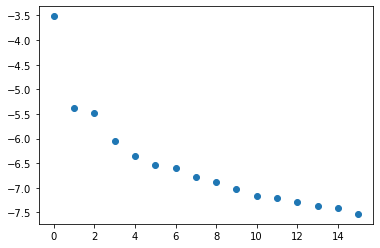

In [5]:
plt.scatter([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],np.log10(σ[0:16]))

In [6]:
#get first 5 modes of K
mode1= np.reshape(U[:,0],(krat.shape[0],1))*sigma[0,0]* np.reshape(VH[0,:], (1,krat.shape[1]))
mode2= np.reshape(U[:,1],(krat.shape[0],1))*sigma[1,1]* np.reshape(VH[1,:], (1,krat.shape[1]))
mode3= np.reshape(U[:,2],(krat.shape[0],1))*sigma[2,2]* np.reshape(VH[2,:], (1,krat.shape[1]))
mode4= np.reshape(U[:,3],(krat.shape[0],1))*sigma[3,3]* np.reshape(VH[3,:], (1,krat.shape[1]))
mode5= np.reshape(U[:,4],(krat.shape[0],1))*sigma[4,4]* np.reshape(VH[4,:], (1,krat.shape[1]))

([<matplotlib.axis.YTick at 0x1198033d0>,
 [Text(0, 0, '0'),
  Text(0, 20, '200'),
  Text(0, 40, '400'),
  Text(0, 60, '600'),
  Text(0, 80, '800'),
  Text(0, 100, '1000'),
  Text(0, 120, '1200')])

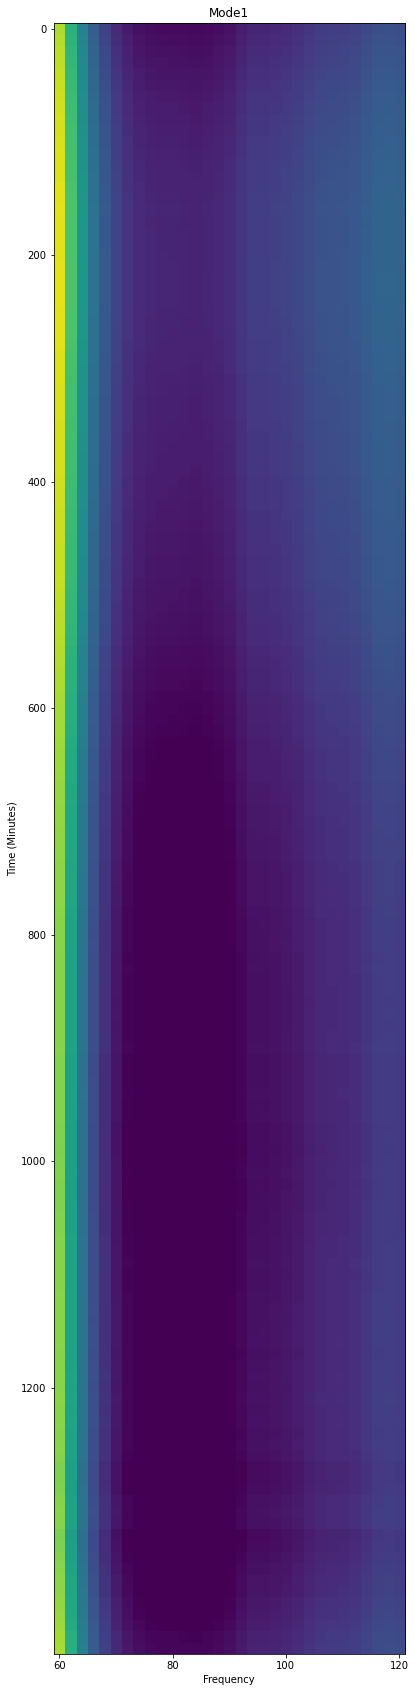

In [7]:
plt.figure(1, figsize=(100, 30))
plt.title('Mode1')
plt.imshow(np.log10(mode1), vmin=-5.4, vmax=-5.1)
plt.xlabel('Frequency')
xlabels=(["60", "80", "100", "120"])
plt.xticks([0, 10, 20, 30], xlabels)
plt.ylabel('Time (Minutes)')
ylabels=(["0", "200", "400", "600", "800", "1000", "1200"])
plt.yticks([0, 20, 40, 60, 80, 100, 120], ylabels)

Text(0, 0.5, 'Mode 1 of Calibration Parameter K')

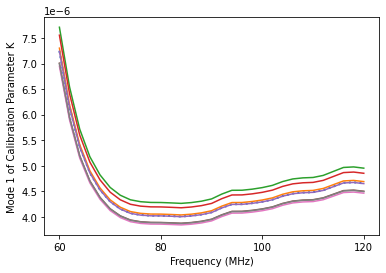

In [11]:
plt.plot(np.mean(mode1, axis=0),lw = 2, ls=':')
plt.plot(mode1[0,:])
plt.plot(mode1[20,:])
plt.plot(mode1[40,:])
plt.plot(mode1[60,:])
plt.plot(mode1[80,:])
plt.plot(mode1[100,:])
plt.plot(mode1[120,:])
labels=(["60", "80", "100", "120"])
plt.xticks([0, 10, 20, 30], labels)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Mode 1 of Calibration Parameter K')
#plt.legend(loc = 'upper right', prop ={'size': 12})

Text(0, 0.5, 'Mode 1 of Calibration Parameter K')

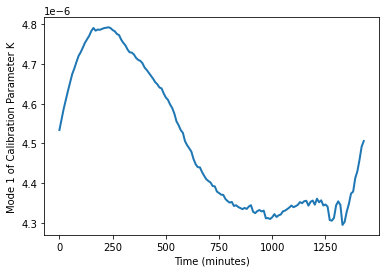

In [14]:
plt.plot(np.mean(mode1, axis=1),lw = 2)
#plt.plot(mode1[:,10],lw = 2, ls = ":")
#plt.plot(mode1[:,20],lw = 2, ls = ":")
labels=(["0", "250","500", "750","1000", "1250"])
plt.xticks([0, 25, 50, 75, 100, 125], labels)
plt.xlabel('Time (minutes)')
plt.ylabel('Mode 1 of Calibration Parameter K')
#plt.legend(loc = 'upper right', prop ={'size': 12})

In [22]:
observed = mode1*alldataavg
poly=3
obs=np.nanmean(observed, axis=0)
v = []
for j in range(flow, fhigh+2, 2):
    v.append(j)
v=np.array(v)
fit = np.polyfit(np.log10(v/100), np.log10(np.abs(obs)), poly)    
power = np.zeros(int((fhigh-flow)/2)+1)
i = 0
while i <= poly:
    power = power + fit[poly-i]*(np.log10(v/100))**i
    i += 1
y = 10**(power)

Text(0.5, 0, 'Frequency (MHz)')

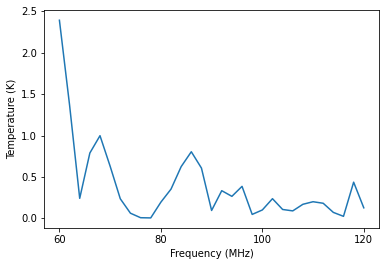

In [23]:
#plt.plot(y, label = 'Sky Model')
#plt.plot(obs,lw = 3, ls = ":", label = 'Observed Data')
plt.plot(abs(y - obs))
labels=(["60", "80", "100", "120"])
plt.xticks([0, 10, 20, 30], labels)
plt.ylabel('Temperature (K)')
plt.xlabel('Frequency (MHz)')
#plt.legend(loc = 'upper right', prop ={'size': 16})